In [1]:
import sys 
#sys.path.insert(1, '/home/users/xwei/COAsT' ) 

import sys
import os
import numpy as np
import numpy.ma as ma
import xarray as xr
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import datetime
import netCDF4
import glob
import pickle
import collections.abc
from cartopy import config
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point as cycpt
from matplotlib.animation import FuncAnimation
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings("ignore") # turning warnings off

In [2]:
sub=5
fn_nemo_dom='/gws/nopw/j04/class_vol1/CLASS-MEDUSA/OUT_eORCA12/C001/domain/domain_cfg.nc'
f_dom=xr.open_dataset(fn_nemo_dom)

lon=f_dom['nav_lon'][3000:3606:sub,::sub]
lat=f_dom['nav_lat'][3000:3606:sub,::sub]
lon.shape
f_dom.close()

fff=xr.open_dataset('/gws/nopw/j04/canari/users/xwei/mask.nc')
e1v=fff['e1v'][::,3000:3606:sub,::sub].squeeze()
e2u=fff['e2u'][::,3000:3606:sub,::sub].squeeze()
fff.close()

weights = e1v*e2u
f_ice_AllYears=xr.open_dataset('/gws/nopw/j04/canari/users/xwei/ice_cover/iceconc_annual_AllYears.nc')#iceconc_annual_AllYears.nc，ice conc. during 1990-2100 #ice conc. in 1981-2100
ice_conc_AllYears=f_ice_AllYears['siconc'][::,0:606:sub,::sub]#read ice data from 1990, instead of 1981
lon_ice=f_dom.variables['nav_lon'][3000:3606:sub,::sub]#[3000:3606:sub,::sub]
lat_ice=f_dom.variables['nav_lat'][3000:3606:sub,::sub]# [3000:3606:sub,::sub]
lon_noNAN_ice=ma.masked_where(np.isnan(ice_conc_AllYears[0,::,::]),lon_ice)
lat_noNAN_ice=ma.masked_where(np.isnan(ice_conc_AllYears[0,::,::]),lat_ice)
lon_noNAN=lon_noNAN_ice
lat_noNAN=lat_noNAN_ice
f_ice_AllYears.close()


PermissionError: [Errno 13] Permission denied: '/gws/nopw/j04/canari/users/xwei/mask.nc'

In [8]:
!pwd

/home/users/cwilso01/projects/canari/CANARI_diagnostics/python/notebooks


In [3]:
f_dom

<xarray.Dataset> Size: 68GB
Dimensions:       (y: 3606, x: 4322, z: 75, t: 1)
Dimensions without coordinates: y, x, z, t
Data variables: (12/43)
    nav_lon       (y, x) float32 62MB ...
    nav_lat       (y, x) float32 62MB ...
    nav_lev       (z) float32 300B ...
    time_counter  (t) float64 8B ...
    jpiglo        int32 4B ...
    jpjglo        int32 4B ...
    ...            ...
    e3uw_0        (t, z, y, x) float64 9GB ...
    e3vw_0        (t, z, y, x) float64 9GB ...
    bottom_level  (t, y, x) int32 62MB ...
    top_level     (t, y, x) int32 62MB ...
    mppmask       (t, y, x) int32 62MB ...
    closea_mask   (y, x) float64 125MB ...
Attributes:
    file_name:                 domain_cfg.nc
    TimeStamp:                 08/05/2018 16:40:23 +0000
    NCO:                       netCDF Operators version 4.9.5 (Homepage = htt...
    history:                   Sat Sep 25 18:14:32 2021: ncks --no_abc --cnk_...
    nco_openmp_thread_number:  1

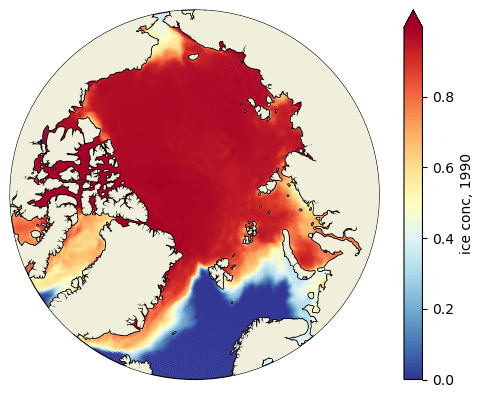

In [3]:
import warnings
warnings.filterwarnings("ignore") # turning warnings off

start_time = datetime.now()
def set_circle(ax):
  # Compute a circle in axes coordinates, which we can use as a boundary for the map.
  theta = np.linspace(0, 2 * np.pi, 100)
  center, radius = [0.5, 0.5], 0.5
  verts = np.vstack([np.sin(theta), np.cos(theta)]).T
  circle = mpath.Path(verts * radius + center)
  ax.set_boundary(circle, transform=ax.transAxes)
    
arctic_projection=ccrs.NorthPolarStereo(central_longitude=0.0, globe=None)#ccrs.PlateCarree()

fig, ax = plt.subplots(subplot_kw={'projection': arctic_projection})
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())#ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
 
scatter = ax.scatter(lon_noNAN,lat_noNAN,c=ice_conc_AllYears[0,::,::],cmap=plt.cm.RdYlBu_r,marker='.',s=2,transform=ccrs.PlateCarree())
scatter.set_cmap(plt.cm.RdYlBu_r)
ax.coastlines(linewidth=1)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=100)
plt.colorbar(scatter, ax=ax, extend='max', orientation="vertical",label="ice conc, 1990")
set_circle(ax)

## CW: read the interfacial work done data that I calculated using "calculate_work_done_atm_ice_ocean_parallel.ipynb"

In [9]:
!ls /gws/nopw/j04/canari/users/cwilso01/eORCA12_NEMO_MEDUSA/work_by_interfacial_stress/1990/

ls: cannot access '/gws/nopw/j04/canari/users/cwilso01/eORCA12_NEMO_MEDUSA/work_by_interfacial_stress/1990/': Permission denied


In [4]:
from pathlib import Path
import xarray as xr

BASE = Path("/gws/nopw/j04/canari/users/cwilso01/eORCA12_NEMO_MEDUSA/work_by_interfacial_stress")

years = range(1990, 2100)   # 1990–2099 inclusive
months = range(1, 13)

# Build expected paths (YYYY/W_terms_yYYYYmMM.nc)
paths = [
    BASE / f"{y:04d}" / f"W_terms_y{y:04d}m{m:02d}.nc"
    for y in years for m in months
]

# Keep only existing files (robust if any are missing)
files = [str(p) for p in paths if p.is_file()]

In [16]:
files[0:10]

['/gws/nopw/j04/canari/users/cwilso01/eORCA12_NEMO_MEDUSA/work_by_interfacial_stress/1990/W_terms_y1990m01.nc',
 '/gws/nopw/j04/canari/users/cwilso01/eORCA12_NEMO_MEDUSA/work_by_interfacial_stress/1990/W_terms_y1990m02.nc',
 '/gws/nopw/j04/canari/users/cwilso01/eORCA12_NEMO_MEDUSA/work_by_interfacial_stress/1990/W_terms_y1990m03.nc',
 '/gws/nopw/j04/canari/users/cwilso01/eORCA12_NEMO_MEDUSA/work_by_interfacial_stress/1990/W_terms_y1990m04.nc',
 '/gws/nopw/j04/canari/users/cwilso01/eORCA12_NEMO_MEDUSA/work_by_interfacial_stress/1990/W_terms_y1990m05.nc',
 '/gws/nopw/j04/canari/users/cwilso01/eORCA12_NEMO_MEDUSA/work_by_interfacial_stress/1990/W_terms_y1990m06.nc',
 '/gws/nopw/j04/canari/users/cwilso01/eORCA12_NEMO_MEDUSA/work_by_interfacial_stress/1990/W_terms_y1990m07.nc',
 '/gws/nopw/j04/canari/users/cwilso01/eORCA12_NEMO_MEDUSA/work_by_interfacial_stress/1990/W_terms_y1990m08.nc',
 '/gws/nopw/j04/canari/users/cwilso01/eORCA12_NEMO_MEDUSA/work_by_interfacial_stress/1990/W_terms_y1990m

In [7]:
if not files:
    raise FileNotFoundError("No matching NetCDF files found. Check BASE path and naming.")

# Open all files as one dataset
ds = xr.open_mfdataset(
    files,
    combine="nested",compat='override',# safest if files have proper coords (time, depth, y, x, etc.)
    parallel=False,           # uses dask if available
    chunks="auto",           # good default; tune if needed
    decode_times=True
)

print(ds)
print(ds.time_centered.min().values, ds.time_centered.max().values)

<xarray.Dataset> Size: 100MB
Dimensions:        (y: 726, x: 4322)
Coordinates:
    time_centered  object 8B ...
    time_counter   object 8B ...
    nav_lat        (y, x) float32 13MB dask.array<chunksize=(726, 4322), meta=np.ndarray>
    nav_lon        (y, x) float32 13MB dask.array<chunksize=(726, 4322), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    W_ao           (y, x) float64 25MB dask.array<chunksize=(726, 4322), meta=np.ndarray>
    W_ai           (y, x) float64 25MB dask.array<chunksize=(726, 4322), meta=np.ndarray>
    W_io           (y, x) float64 25MB dask.array<chunksize=(726, 4322), meta=np.ndarray>
1990-01-16 00:00:00 1990-01-16 00:00:00


In [27]:
print(ds.dims)
print(ds["time_counter"].shape)


FrozenMappingWarningOnValuesAccess({'y': 726, 'x': 4322})
()


In [8]:
import xarray as xr
import numpy as np

def add_time_dim(ds: xr.Dataset) -> xr.Dataset:
    if "time_centered" not in ds:
        raise KeyError("Expected 'time_centered' not found.")

    t = ds["time_centered"].values

    # Convert 0-d / 1-element arrays to a scalar (prevents object-of-ndarray)
    if isinstance(t, np.ndarray):
        if t.shape == ():          # 0-d array
            t = t.item()
        elif t.size == 1:          # 1-element array
            t = t.reshape(()).item()

    ds = ds.expand_dims(time=[t])
    ds = ds.assign_coords(time_centered=("time", [t]))
    return ds


ds = xr.open_mfdataset(
    files,
    combine="nested",
    concat_dim="time",
    preprocess=add_time_dim,
    compat="override",
    coords="minimal",
    data_vars="minimal",
    join="override",
    parallel=True,
    chunks={"time": 120, "y": 121, "x": 720},
    decode_times=True,
    engine="netcdf4",
)

# (optional but recommended) ensure time chunks are actually 120 once you have enough months
ds = ds.chunk({"time": 120, "y": 121, "x": 720})


In [9]:
decade = (ds["time_centered"].dt.year // 10) * 10
decadal = ds.groupby(decade.rename("decade")).mean("time")


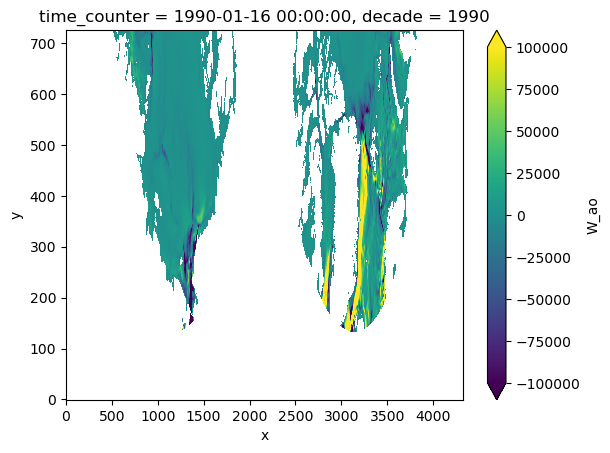

In [39]:
decadal.W_ao[0,:,:].plot(vmin=-1e5,vmax=1e5)

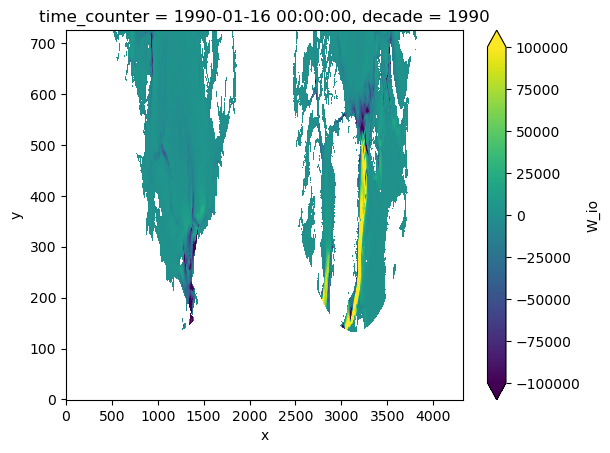

In [40]:
decadal.W_io[0,:,:].plot(vmin=-1e5,vmax=1e5)

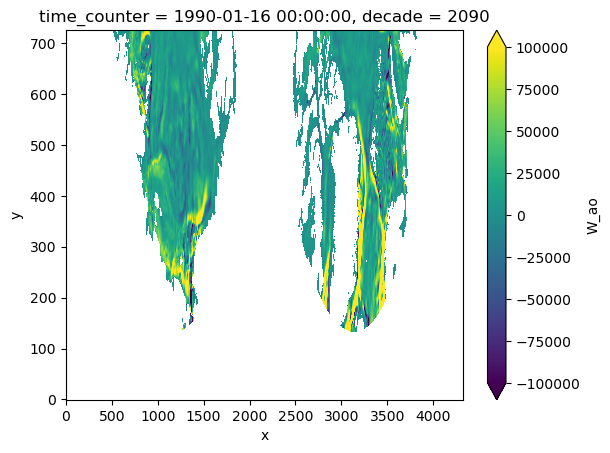

In [10]:
decadal.W_ao[10,:,:].plot(vmin=-1e5,vmax=1e5)

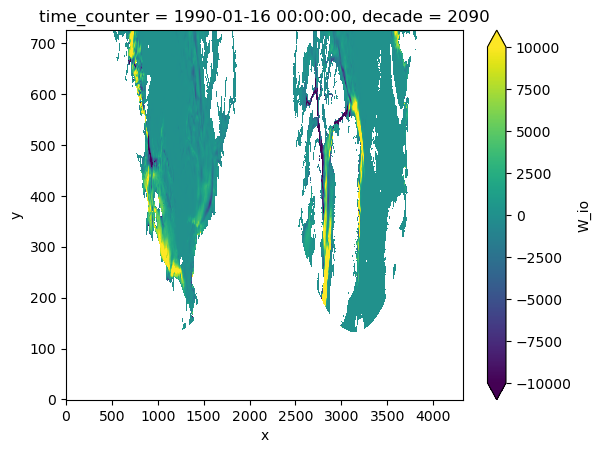

In [14]:
decadal.W_io[10,:,:].plot(vmin=-1e5,vmax=1e5)

In [15]:
decadal.W_io

<xarray.DataArray 'W_io' (decade: 11, y: 726, x: 4322)> Size: 276MB
dask.array<concatenate, shape=(11, 726, 4322), dtype=float64, chunksize=(1, 121, 720), chunktype=numpy.ndarray>
Coordinates:
    time_counter  object 8B ...
    nav_lat       (y, x) float32 13MB dask.array<chunksize=(121, 720), meta=np.ndarray>
    nav_lon       (y, x) float32 13MB dask.array<chunksize=(121, 720), meta=np.ndarray>
  * decade        (decade) int64 88B 1990 2000 2010 2020 ... 2060 2070 2080 2090
Dimensions without coordinates: y, x

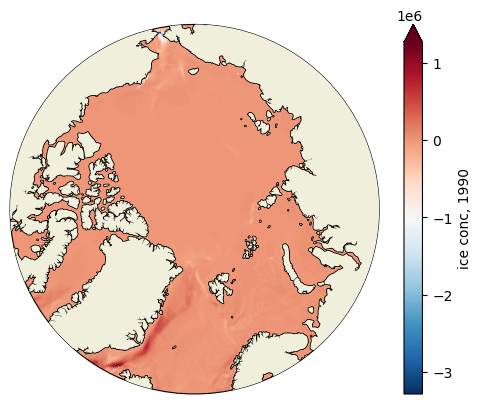

In [17]:
W_ao=decadal['W_ao'][::,120:726:sub,::sub]# subsample
W_ai=decadal['W_ai'][::,120:726:sub,::sub]# subsample


import warnings
warnings.filterwarnings("ignore") # turning warnings off

start_time = datetime.now()
def set_circle(ax):
  # Compute a circle in axes coordinates, which we can use as a boundary for the map.
  theta = np.linspace(0, 2 * np.pi, 100)
  center, radius = [0.5, 0.5], 0.5
  verts = np.vstack([np.sin(theta), np.cos(theta)]).T
  circle = mpath.Path(verts * radius + center)
  ax.set_boundary(circle, transform=ax.transAxes)
    
arctic_projection=ccrs.NorthPolarStereo(central_longitude=0.0, globe=None)#ccrs.PlateCarree()

fig, ax = plt.subplots(subplot_kw={'projection': arctic_projection})
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())#ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
 
scatter = ax.scatter(lon_noNAN,lat_noNAN,c=W_ao[0,::,::],cmap=plt.cm.RdBu_r,marker='.',s=2,transform=ccrs.PlateCarree())
scatter.set_cmap(plt.cm.RdBu_r)
ax.coastlines(linewidth=1)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=100)
plt.colorbar(scatter, ax=ax, extend='max', orientation="vertical",label="ice conc, 1990")
set_circle(ax)

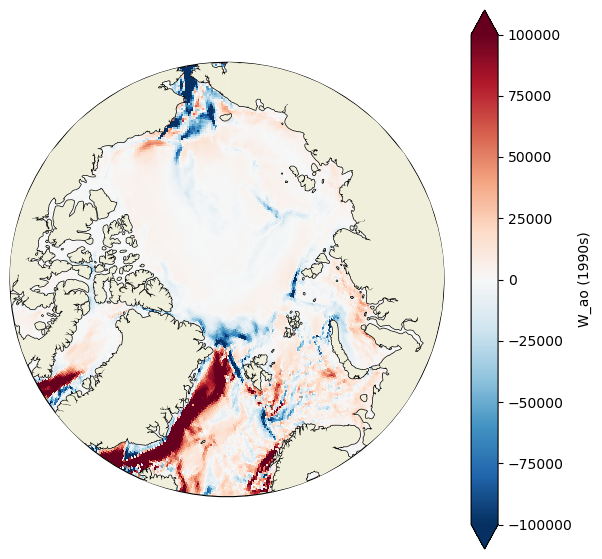

In [19]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath

def set_circle(ax):
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

# --- choose the decade index you want ---
W0 = W_ao.isel(decade=0).values  # adapt dim name if it's not "decade"

# Ensure W is masked in the same places as your lon/lat mask (ice mask)
# (this avoids plotting garbage at masked points)
W0m = ma.array(W0, mask=ma.getmaskarray(lon_noNAN))

# Fixed symmetric range and zero-centred diverging normalization
norm = colors.TwoSlopeNorm(vmin=-1e5, vcenter=0.0, vmax=1e5)

proj = ccrs.NorthPolarStereo(central_longitude=0.0)
fig, ax = plt.subplots(subplot_kw={"projection": proj}, figsize=(7, 7))

ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=100)
ax.coastlines(linewidth=1)

mesh = ax.pcolormesh(
    lon_noNAN, lat_noNAN, W0m,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    norm=norm,
    shading="auto",
)

cb = plt.colorbar(mesh, ax=ax, extend="both", orientation="vertical", label="W_ao (1990s)")
set_circle(ax)

plt.show()


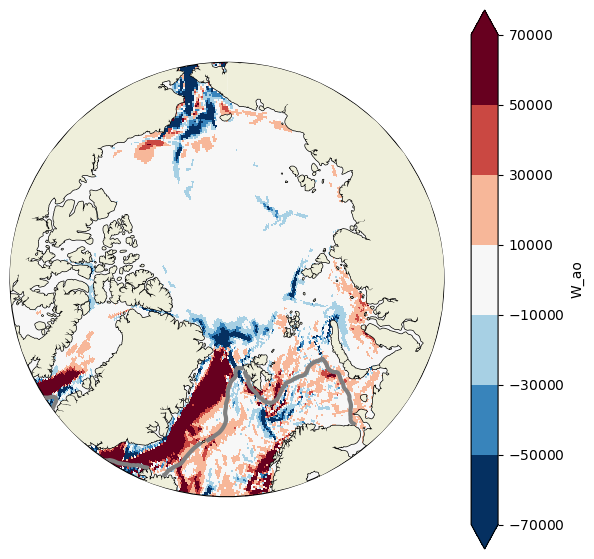

In [40]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath

def set_circle(ax):
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

# Choose decade index
idec = 0  # 0->1990s, 1->2000s, ...

# Pull one 2D field (load only this slice if dask-backed)
W0 = W_ao.isel(decade=idec).load().values

# Apply the same mask as your lon/lat (ice mask)
W0 = ma.array(W0, mask=ma.getmaskarray(lon_noNAN))

# Fixed symmetric range with 0 centered
norm = colors.TwoSlopeNorm(vmin=-1e5, vcenter=0.0, vmax=1e5)

proj = ccrs.NorthPolarStereo(central_longitude=0.0)
fig, ax = plt.subplots(subplot_kw={"projection": proj}, figsize=(7, 7))

ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=100)
ax.coastlines(linewidth=1)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

vmax = 7e4
nbins = 7

# Create symmetric bin edges (N edges → N-1 bins)
bounds = np.linspace(-vmax, vmax, nbins + 1)

cmap = plt.get_cmap("RdBu_r", nbins)  # discretized to nbins colours
norm = mcolors.BoundaryNorm(bounds, cmap.N)

m = ax.pcolormesh(
    lon_noNAN, lat_noNAN, W0,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    shading="auto"
)

cb = plt.colorbar(
    m,
    ax=ax,
    boundaries=bounds,
    ticks=bounds,
    extend="both"
)

cb.set_label("W_ao")
from matplotlib.ticker import ScalarFormatter
cb.formatter = ScalarFormatter(useMathText=True)
cb.update_ticks()


import numpy as np
import xarray as xr
import numpy.ma as ma
import cartopy.crs as ccrs

# decadal mean ice
decade_ice = (ice_conc_AllYears["time_counter"].dt.year // 10) * 10
ice_decadal = ice_conc_AllYears.groupby(decade_ice.rename("decade")).mean("time_counter")

idec = 0  # same decade index you used for W_ao
ice_plot = ice_decadal.isel(decade=idec)

lon2 = lon_noNAN
lat2 = lat_noNAN

# Mask bad values / land.
## Choose ONE of the following depending on how land is encoded in your siconc:
ice2 = ice_plot.values.astype("float64")

# Always drop NaNs/infs
ice2 = np.where(np.isfinite(ice2), ice2, np.nan)

# If land is 0 in your ice product, this prevents the coastline from becoming a "feature"
# (common in model outputs; adjust threshold if needed)
ice2 = np.where(ice2 > 0, ice2, np.nan)

# Now overlay the contour
ax.contour(
    lon2, lat2, ice2,
    levels=[0.15],
    colors=["0.5"],      # grey
    linewidths=3.0,
    transform=ccrs.PlateCarree(),
    zorder=400,
    transform_first=False # often helps for polar projections
)



set_circle(ax)
plt.show()


In [42]:
W_ai=decadal['W_ai'][::,120:726:sub,::sub]# subsample


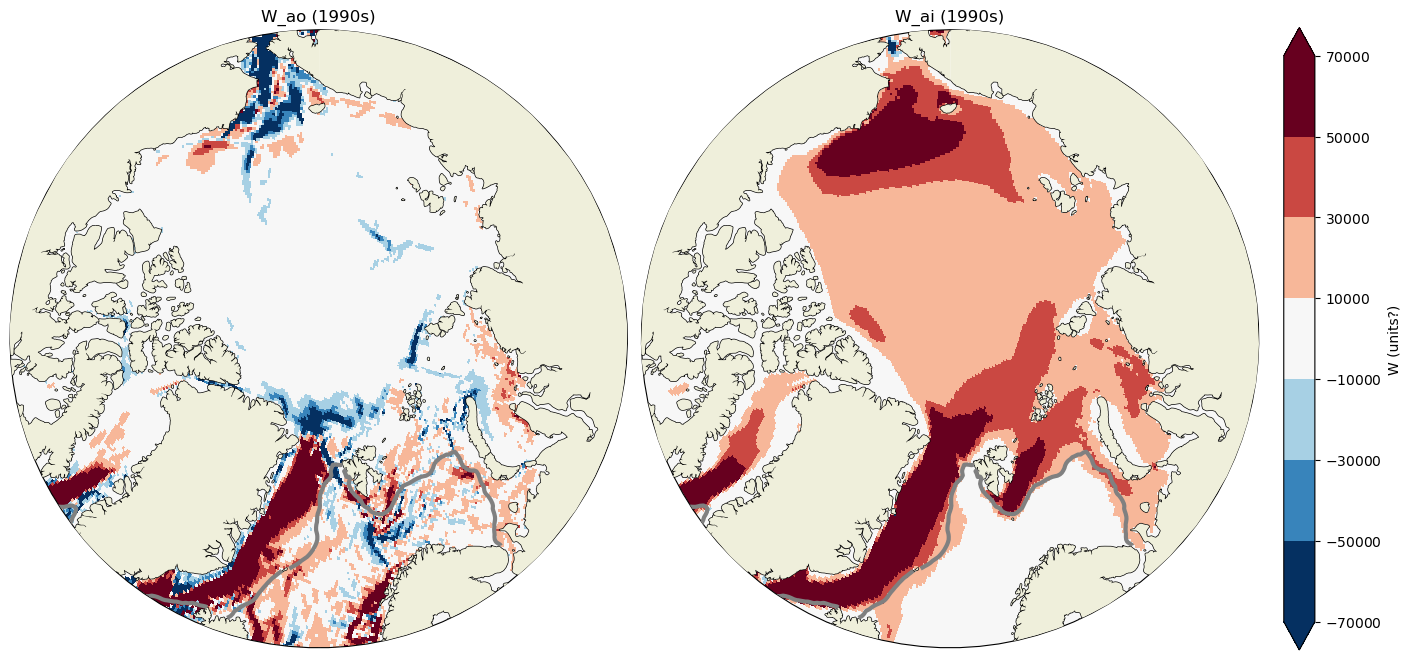

In [43]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath

def set_circle(ax):
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

# ----------------------------
# Settings
# ----------------------------
idec = 0  # 0->1990s
vmax = 7e4
nbins = 7
bounds = np.linspace(-vmax, vmax, nbins + 1)         # nbins bins
cmap = plt.get_cmap("RdBu_r", nbins)                 # discrete colormap
norm = mcolors.BoundaryNorm(bounds, cmap.N)

proj = ccrs.NorthPolarStereo(central_longitude=0.0)
pc = ccrs.PlateCarree()

# ----------------------------
# Data slices (load only what you plot)
# ----------------------------
W0_ao = W_ao.isel(decade=idec).load().values
W0_ai = W_ai.isel(decade=idec).load().values

# Apply same mask as lon/lat (your existing ice-based mask)
mask_xy = ma.getmaskarray(lon_noNAN)
W0_ao = ma.array(W0_ao, mask=mask_xy)
W0_ai = ma.array(W0_ai, mask=mask_xy)

# Decadal mean ice for contour
decade_ice = (ice_conc_AllYears["time_counter"].dt.year // 10) * 10
ice_decadal = ice_conc_AllYears.groupby(decade_ice.rename("decade")).mean("time_counter")
ice2 = ice_decadal.isel(decade=idec).values.astype("float64")

# Mask invalid + land (assuming land==0 for this product)
ice2 = np.where(np.isfinite(ice2), ice2, np.nan)
ice2 = np.where(ice2 > 0, ice2, np.nan)

# ----------------------------
# Figure with two panels
# ----------------------------
fig, axs = plt.subplots(
    nrows=1, ncols=2,
    subplot_kw={"projection": proj},
    figsize=(14, 7),
    constrained_layout=True
)

titles = ["W_ao (1990s)", "W_ai (1990s)"]
fields = [W0_ao, W0_ai]
meshes = []

for ax, title, field in zip(axs, titles, fields):
    ax.set_extent([-180, 180, 65, 90], pc)
    ax.add_feature(cfeature.LAND, zorder=100)
    ax.coastlines(linewidth=1)
    set_circle(ax)
    ax.set_title(title)

    m = ax.pcolormesh(
        lon_noNAN, lat_noNAN, field,
        transform=pc,
        cmap=cmap,
        norm=norm,
        shading="auto",
        zorder=1
    )
    meshes.append(m)

    # Ice edge contour
    ax.contour(
        lon_noNAN, lat_noNAN, ice2,
        levels=[0.15],
        colors=["0.5"],
        linewidths=3.0,
        transform=pc,
        zorder=400,
        transform_first=False
    )

# Shared colorbar (uses the first mappable; same norm/cmap for both)
cb = fig.colorbar(
    meshes[0],
    ax=axs,
    boundaries=bounds,
    ticks=bounds,
    extend="both",
    orientation="vertical",
    shrink=0.9,
    pad=0.02
)
cb.set_label("W (watt)")
cb.formatter = ScalarFormatter(useMathText=True)
cb.update_ticks()

plt.show()


In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import coast

f_tau_uo_AllYears=xr.open_dataset("/gws/nopw/j04/canari/users/xwei/monthly_wind/tauuo_AllYears.nc") #u wind stress data from 1990 to 2100
f_tau_vo_AllYears=xr.open_dataset("/gws/nopw/j04/canari/users/xwei/monthly_wind/tauvo_AllYears.nc") #u wind stress data from 1990 to 2100
tau_uo_AllYears=f_tau_uo_AllYears['tauuo'][-111:-1,0:606:sub,::sub] 
tau_vo_AllYears=f_tau_vo_AllYears['tauvo'][-111:-1,0:606:sub,::sub] 
f_siconc_AllYears=xr.open_dataset("/gws/nopw/j04/canari/users/xwei/ice_cover/iceconc_annual_AllYears.nc")   #ice thickness and volume during 1990-2100
ice_conc_AllYears=f_siconc_AllYears['siconc'][-111:-1, 0:606:sub, ::sub] 
f_siconc_AllYears.close()

f_tau_uo_AllYears.close()
f_tau_vo_AllYears.close()
tau_uo_AllYears.shape

f_annual_vo=xr.open_dataset('/gws/nopw/j04/canari/users/xwei/AnnualMean_V_AllYears_Arctic.nc')
vs_AllYears=f_annual_vo['vo'][:,0,0:606:sub,::sub] 
f_annual_uo=xr.open_dataset('/gws/nopw/j04/canari/users/xwei/AnnualMean_U_AllYears_Arctic.nc')
us_AllYears=f_annual_uo['uo'][:,0,0:606:sub,::sub] 
print(us_AllYears.shape)

ModuleNotFoundError: No module named 'xarray.ufuncs'

In [ ]:
#Create bathymetry map
 

bathy_file = xr.open_dataset('/gws/nopw/j04/class_vol1/CLASS-MEDUSA/OUT_eORCA12/C001/domain/mesh_mask.nc')
mbathy = bathy_file['mbathy'][0, 3000:3606:sub, ::sub].astype(np.int32)
thickness_cell = bathy_file['gdept_0'][0, :, 3000:3606:sub, ::sub]
thickness_cell_1d = bathy_file['gdept_1d']

# Prepare
depths = np.zeros_like(mbathy, dtype=float)

# Mask valid indices
valid_mask = (mbathy > 0) & (mbathy < 100)

# Get the flattened indices of valid cells
i_idx, j_idx = np.where(valid_mask)
k_idx = mbathy.values[i_idx, j_idx]

# Vectorized lookup: depths[z, y, x] = thickness_cell[k, y, x]
depths[i_idx, j_idx] = thickness_cell.values[k_idx, i_idx, j_idx]

print("Depths computed for valid cells:", depths.shape)

In [ ]:
WindWork_AllYears=tau_uo_AllYears*us_AllYears+tau_vo_AllYears*vs_AllYears
WindWork_AllYears_IceFree = ma.masked_where(ice_conc_AllYears > 0.15, WindWork_AllYears)
WindWork_AllYears_IceFree_filled = WindWork_AllYears_IceFree.filled(0)


lon_cond = ((lon < -128) & (lon > -165)) & (depths>300) #Beaufort Sea
lat_cond = (lat > 70) & (lat<85)
mask0 = lon_cond & lat_cond

lon_cond1 = ((lon < -128) | (lon > 150)) & (depths>300) #Canada Basin
lat_cond = lat > 70
mask1 = lon_cond1 & lat_cond

lon_cond2 = (lon > -60) & (lon < 140)  & (depths>300) # Eurasian Basin
mask2=lon_cond2 & (lat > 82)


 


In [ ]:
WindWork_AllYears_IceFree_BeaufortSea = (WindWork_AllYears*(1-np.array(ice_conc_AllYears))).where(mask0, 0)
WindWork_AllYears_IceFree_EurasianBasin = (WindWork_AllYears*(1-np.array(ice_conc_AllYears))).where(mask2, 0)

WindWork_weighted_sum_IceFree = np.zeros(np.shape(ice_conc_AllYears)[0])
WindWork_weighted_sum_BeaufortSea = np.zeros(np.shape(ice_conc_AllYears)[0])
WindWork_weighted_sum_EurasianBasin = np.zeros(np.shape(ice_conc_AllYears)[0])

for i in range(np.shape(ice_conc_AllYears)[0]):
    #print(i)
    WindWork_weighted_sum_IceFree[i] = np.nansum(WindWork_AllYears_IceFree_filled[i, :, :].squeeze()*weights, axis=(0, 1))
    WindWork_weighted_sum_BeaufortSea[i] = np.nansum(WindWork_AllYears_IceFree_BeaufortSea[i, :, :].squeeze()*weights, axis=(0, 1))
    WindWork_weighted_sum_EurasianBasin[i] = np.nansum(WindWork_AllYears_IceFree_EurasianBasin[i, :, :].squeeze()*weights, axis=(0, 1))


In [11]:
f_iceStress_AllYears=xr.open_dataset('/gws/nopw/j04/canari/users/xwei/ice_cover/ice_speed_stress_AllYears_Arctic.nc')
utau_ai_AllYears=f_iceStress_AllYears['utau_ai'][-111:-1,0:606:sub,::sub] #  X-component of atmospheric stress on sea ice
vtau_ai_AllYears=f_iceStress_AllYears['vtau_ai'][-111:-1,0:606:sub,::sub] 
utau_oi_AllYears=f_iceStress_AllYears['utau_oi'][-111:-1,0:606:sub,::sub] #  X-component of ocean stress on sea ice
vtau_oi_AllYears=f_iceStress_AllYears['vtau_oi'][-111:-1,0:606:sub,::sub] 
f_iceStress_AllYears.close()

In [15]:
IceWork_oi_AllYears=-utau_oi_AllYears*us_AllYears*np.array(ice_conc_AllYears)-vtau_oi_AllYears*vs_AllYears*np.array(ice_conc_AllYears) # ocean stress tau on sea ice means sea ice stress on the ocean surface (-tau)
#IceWork_AllYears_IceCovered1 = ma.masked_where(ice_conc_AllYears < 0.15, IceWork_oi_AllYears)

IceWork_AllYears_IceCovered =IceWork_oi_AllYears
IceWork_AllYears_BeaufortSea=IceWork_oi_AllYears.where(mask0)
IceWork_AllYears_EurasianBasin=IceWork_oi_AllYears.where(mask2)

IceWork_weighted_sum = np.zeros(np.shape(ice_conc_AllYears)[0])
IceWork_weighted_BeaufortSea = np.zeros(np.shape(ice_conc_AllYears)[0])
IceWork_weighted_EurasianBasin = np.zeros(np.shape(ice_conc_AllYears)[0])

for i in range(np.shape(ice_conc_AllYears)[0]):
    #print(i)
    IceWork_weighted_sum[i] = np.nansum(IceWork_AllYears_IceCovered[i, :, :].squeeze()*weights, axis=(0, 1))
    IceWork_weighted_BeaufortSea[i] = np.nansum(IceWork_AllYears_BeaufortSea[i, :, :].squeeze()*weights, axis=(0, 1))
    IceWork_weighted_EurasianBasin[i] = np.nansum(IceWork_AllYears_EurasianBasin[i, :, :].squeeze()*weights, axis=(0, 1))



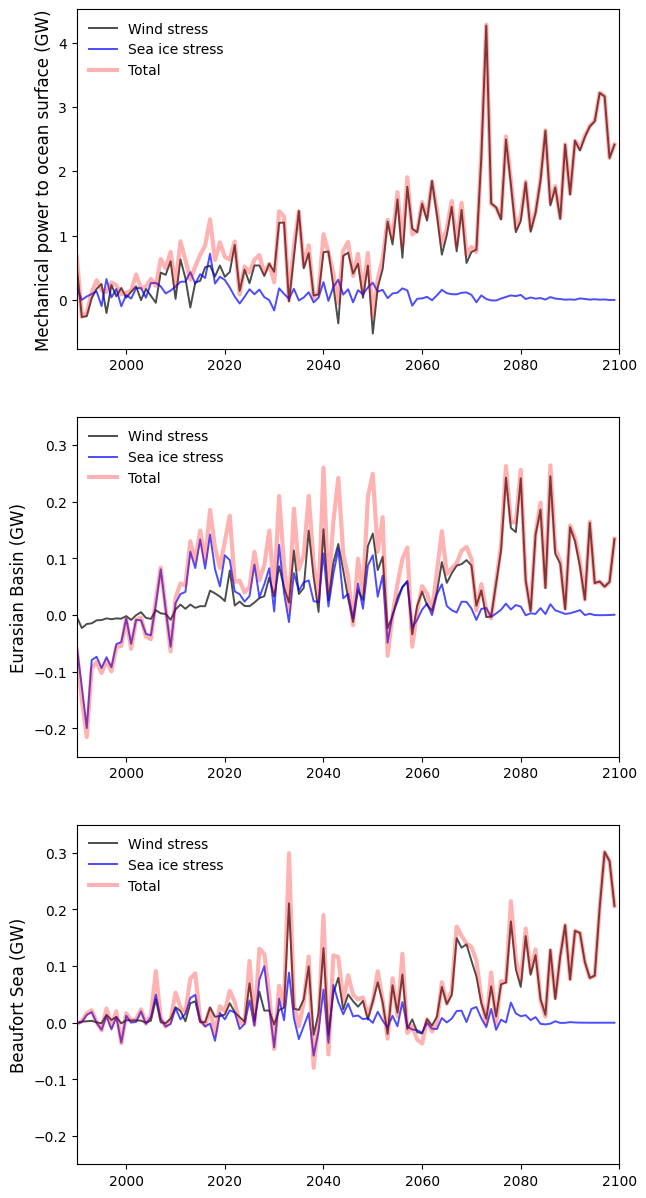

In [27]:
fig,(ax0,ax2,ax1) = plt.subplots(ncols=1,nrows=3,figsize=(7,15))
z0_plot=ax0.plot(np.arange(1990, 2100,1),WindWork_weighted_sum_IceFree/1e9,color='black', linewidth=1.4, alpha=0.7,label='Wind stress')
z0_plot=ax0.plot(np.arange(1990, 2100,1),IceWork_weighted_sum/1e9,color='blue', linewidth=1.4, alpha=0.7,label='Sea ice stress')
z0_plot=ax0.plot(np.arange(1990, 2100,1),IceWork_weighted_sum/1e9+WindWork_weighted_sum_IceFree/1e9,color='red', linewidth=3, alpha=0.3,label='Total')
ax0.legend(ncol=1, frameon=False)
ax0.set_ylabel('Mechanical power to ocean surface (GW)',fontsize=12) 
ax0.set_xlim([1990,2100])
ax0.set_xlabel('', fontsize=12)

z1_plot=ax1.plot(np.arange(1990, 2100,1),WindWork_weighted_sum_BeaufortSea/1e9,color='black', linewidth=1.4, alpha=0.7,label='Wind stress')
z1_plot=ax1.plot(np.arange(1990, 2100,1),IceWork_weighted_BeaufortSea/1e9,color='blue', linewidth=1.4, alpha=0.7,label='Sea ice stress')
z1_plot=ax1.plot(np.arange(1990, 2100,1),IceWork_weighted_BeaufortSea/1e9+WindWork_weighted_sum_BeaufortSea/1e9,color='red', linewidth=3, alpha=0.3,label='Total')
ax1.legend(ncol=1, frameon=False)
ax1.set_ylabel('Beaufort Sea (GW)',fontsize=12) 
ax1.set_xlim([1990,2100])
ax1.set_ylim([-0.25,0.35])
ax1.set_xlabel('', fontsize=12)

z2_plot=ax2.plot(np.arange(1990, 2100,1),WindWork_weighted_sum_EurasianBasin/1e9,color='black', linewidth=1.4, alpha=0.7,label='Wind stress')
z2_plot=ax2.plot(np.arange(1990, 2100,1),IceWork_weighted_EurasianBasin/1e9,color='blue', linewidth=1.4, alpha=0.7,label='Sea ice stress')
z2_plot=ax2.plot(np.arange(1990, 2100,1),IceWork_weighted_EurasianBasin/1e9+WindWork_weighted_sum_EurasianBasin/1e9,color='red', linewidth=3, alpha=0.3,label='Total')
ax2.legend(ncol=1, frameon=False)
ax2.set_ylabel('Eurasian Basin (GW)',fontsize=12) 
ax2.set_xlim([1990,2100])
ax2.set_ylim([-0.25,0.35])
ax2.set_xlabel('', fontsize=12)
plt.savefig('plots/wind_work_ice_work_integrated_sub2_total_BeaufortSea_EurasianBasin_27Nov2025.png',bbox_inches='tight',dpi=400)
#plt.savefig('plots/wind_work_ice_work_integrated3_6June2025.png',bbox_inches='tight',dpi=400)

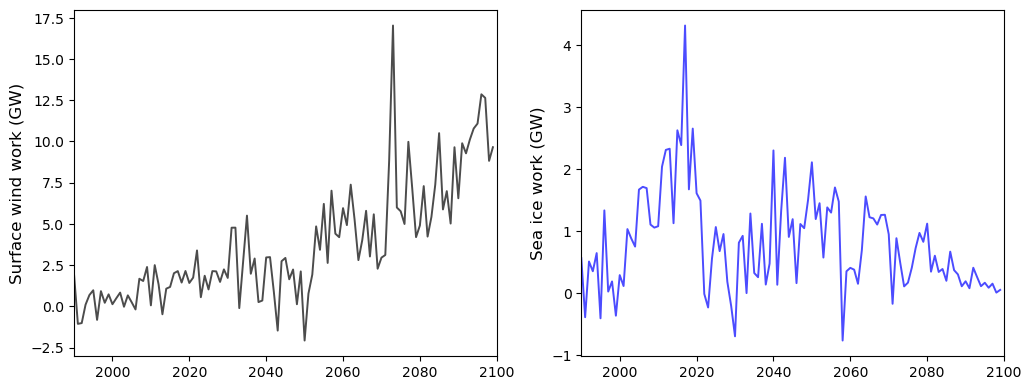

In [13]:
fig,(ax0,ax1) = plt.subplots(ncols=2,nrows=1,figsize=(12,4.5))
z0_plot=ax0.plot(np.arange(1990, 2100,1),WindWork_weighted_sum/1e9,color='black', linewidth=1.4, alpha=0.7)
#ax0.plot(np.arange(1990, 2100,1),np.nanmean(speed_running_mean,axis=1))
ax0.set_xlim([1990,2100])
ax0.set_ylabel('Surface wind work (GW)',fontsize=12) 
#ax0.set_ylim([-20,70])
ax0.set_xlabel('', fontsize=12)
z1_plot=ax1.plot(np.arange(1990, 2100,1),IceWork_weighted_sum/1e9,color='blue', linewidth=1.4, alpha=0.7)
#ax0.plot(np.arange(1990, 2100,1),np.nanmean(speed_running_mean,axis=1))
ax1.set_ylabel('Sea ice work (GW)',fontsize=12) 
ax1.set_xlim([1990,2100])
ax1.set_xlabel('', fontsize=12)
plt.savefig('plots/wind_work_ice_work_integrated.png',bbox_inches='tight',dpi=400)

In [6]:
def set_circle(ax):
  # Compute a circle in axes coordinates, which we can use as a boundary for the map.
  theta = np.linspace(0, 2 * np.pi, 100)
  center, radius = [0.5, 0.5], 0.5
  verts = np.vstack([np.sin(theta), np.cos(theta)]).T
  circle = mpath.Path(verts * radius + center)
  ax.set_boundary(circle, transform=ax.transAxes)

arctic_projection=ccrs.NorthPolarStereo(central_longitude=0.0, globe=None)


In [ ]:
fig, (ax) = plt.subplots(ncols=1, subplot_kw={'projection':  arctic_projection})
ax.scatter(lon_noNAN[::sub,::sub],lat_noNAN[::sub,::sub],s=10, marker='.',c=SLP_AllYears_1990s[::sub,::sub],vmin=1008, vmax=1023,transform=ccrs.PlateCarree(),\
                      cmap='RdBu_r')#cmap='cividis')  

ax.set_extent([-180,180, 65, 85], ccrs.PlateCarree()) 
ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=100)
ax.plot(lon[420,3250],lat[420,3250],'ko',transform=ccrs.PlateCarree())
ax.plot(lon[580,1400],lat[580,1400],'go',transform=ccrs.PlateCarree())
ax.plot(lon[500,1000],lat[500,1000],'bo',transform=ccrs.PlateCarree())
#ax.plot(lon[450,1300],lat[450,1300],'yo',transform=ccrs.PlateCarree())
#ax.plot(lon[440,1500],lat[440,1500],'mo',transform=ccrs.PlateCarree())
ax.plot(lon[400,1400],lat[400,1400],'co',transform=ccrs.PlateCarree())

In [7]:
import pyproj
from scipy.interpolate import griddata
# This plot_polar_contour function was written by Ben, added on 23-11-2023

lat_min=65

def plot_polar_contour(lon, lat, var, ax_in, **kwargs):
    transformer = pyproj.Transformer.from_crs("epsg:3413", "epsg:4326", always_xy=True)
    x_grid, y_grid = np.meshgrid(np.linspace(-3850, 3750, 304) * 1000, np.linspace(-5350, 5850, 448) * 1000)
    lon_grid, lat_grid = transformer.transform(x_grid, y_grid)
    points = np.vstack((lon.flatten(), lat.flatten())).T
    grid_var = griddata(points, var.flatten(), (lon_grid, lat_grid), method="linear") #fill_value=0
    cs_out = ax_in.contour(x_grid, y_grid, grid_var, transform=ccrs.epsg(3413), **kwargs)
    plt.clabel(cs_out, inline=False, fontsize=1, colors='white')

    return cs_out

import warnings
warnings.filterwarnings("ignore") # turning warnings off

In [8]:
f_air_pressure=xr.open_dataset("/gws/nopw/j04/canari/users/xwei/air_pressure/air_pressure_AllYears.nc") #u wind stress data from 1990 to 2100
SLP_AllYears=1013.25*f_air_pressure['ATM_PP0'][::,0:606:sub,::sub] #change units from atm to hPa by multiplying 1013.25
SLP_AllYears.shape

(111, 122, 865)

100%|██████████| 12/12 [00:15<00:00,  1.29s/it]


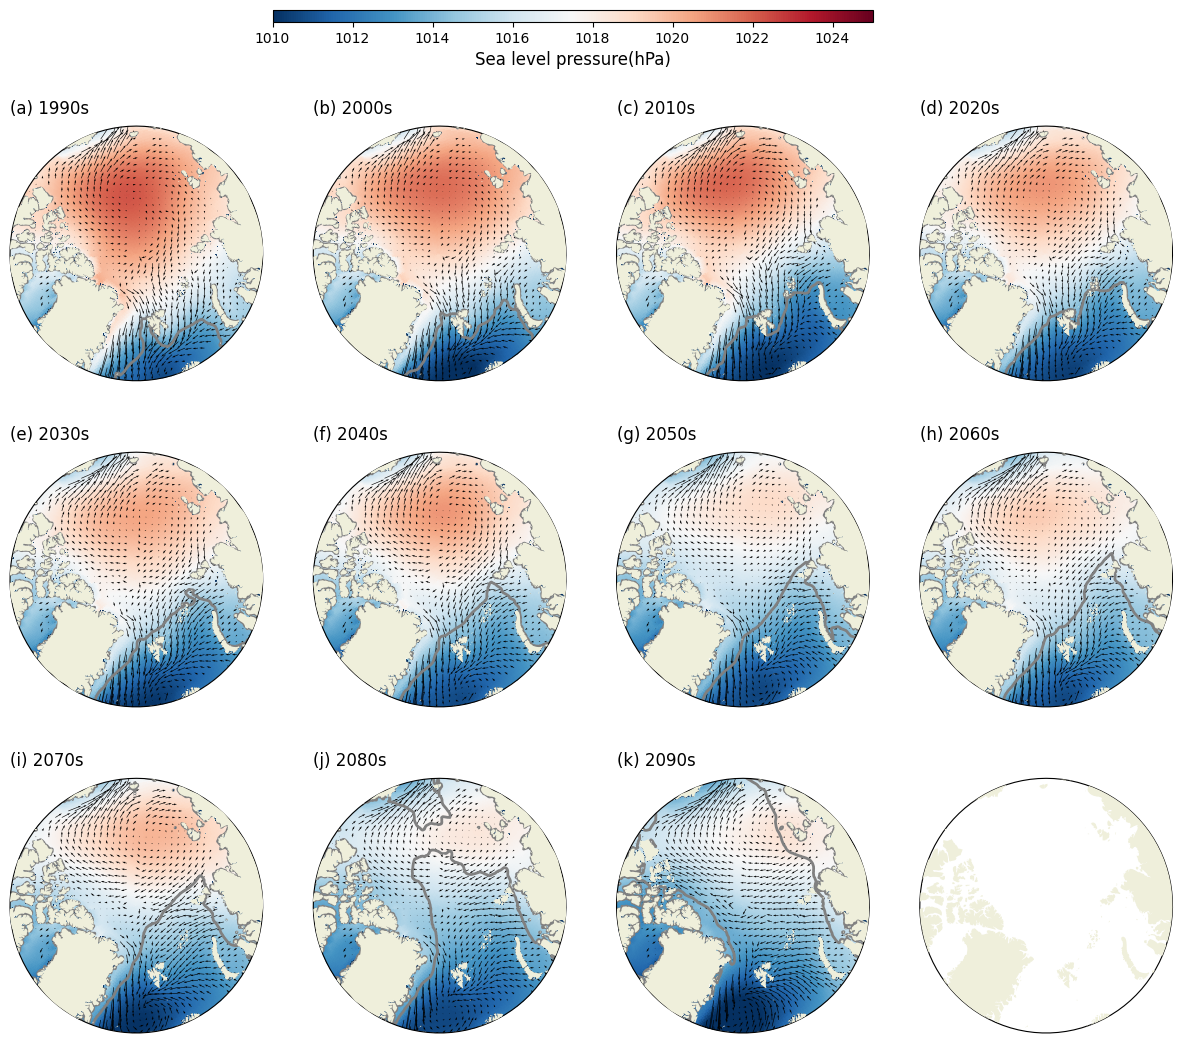

In [20]:
# create wind vectors on top of sea level pressure data

tau_uo_AllYears_log=tau_uo_AllYears#np.sign(tau_uo_AllYears.values) * np.log2(np.abs(tau_uo_AllYears.values))
tau_vo_AllYears_log=tau_vo_AllYears#np.sign(tau_vo_AllYears.values) * np.log2(np.abs(tau_vo_AllYears.values))
                                                              
sub2=10
data_crs = ccrs.PlateCarree()
# Plot projection
mrc = ccrs.NorthPolarStereo(central_longitude=0.0)
# Subplot axes settings
n_r = 3  # Number of subplot rows
n_c = 4  # Number of subplot columns
figsize = (15, 12)#(10, 10)  # Figure size
subplot_padding = 0.5  # Amount of vertical and horizontal padding between plots
fig_pad = (0.075, 0.075, 0.1, 0.1)  # Figure padding (left, top, right, bottom)

# Labels and Titles
fig_title = "Velocity Plot"  # Whole figure title

decade_labels = ['(a) 1990s', '(b) 2000s', '(c) 2010s', '(d) 2020s',
                 '(e) 2030s', '(f) 2040s','(g) 2050s', '(h) 2060s',
                 '(i) 2070s', '(j) 2080s','(k) 2090s'] # extend as needed

# Create plot and flatten axis array
fig, ax = plt.subplots(n_r, n_c, subplot_kw={"projection": mrc}, sharey=True, sharex=True, figsize=figsize)
cax = fig.add_axes([0.3, 0.96, 0.4, 0.01])

ax = ax.flatten()
for rr in range(n_r * n_c):
    ax[rr].add_feature(cfeature.LAND, zorder=100)
    #ax[rr].gridlines()
    ax[rr].set_extent([-180, 180, 70, 90], crs=data_crs)
    coast._utils.plot_util.set_circle(ax[rr])

i=-1
for ip in range(0,11,1): #[0,4,8,10]:
    i+=1
    label=decade_labels[i]
    SLP_slice=SLP_AllYears[10*ip:10*(ip+1),::,::].mean(axis=0).squeeze()  
    cs=ax[i].pcolormesh(lon.values, lat.values, SLP_slice.values, transform=data_crs, vmin=1010, vmax=1025,cmap='RdBu_r')
    contour_set = plot_polar_contour(lon_noNAN_ice, lat_noNAN_ice, ice_conc_AllYears[ip*10:(ip+1)*10,::,::].mean(axis=0).values,ax[i], levels=[0.15],  colors='grey',linestyles='-', linewidths=2)
    uv_velocities = [tau_uo_AllYears_log[10*ip:10*(ip+1),::sub2, ::sub2].mean(axis=0).squeeze() , tau_vo_AllYears_log[10*ip:10*(ip+1), ::sub2, ::sub2].mean(axis=0).squeeze() ]
    u_new, v_new = coast._utils.plot_util.velocity_grid_to_geo(lon[::sub2,::sub2].values, lat[::sub2,::sub2].values,uv_velocities,polar_stereo_cartopy_bug_fix=False)
    u_pol, v_pol = coast._utils.plot_util.velocity_polar_bug_fix(u_new, v_new, lat[::sub2,::sub2].values)
    ax[i].quiver(lon[::sub2,::sub2].values, lat[::sub2,::sub2].values, u_pol, v_pol, color='k', transform=data_crs, angles='xy', regrid_shape=40,scale = 0.75)
    decade=1990+ip*10
    ax[i].annotate(label, (0.0, 1.05), xycoords='axes fraction', zorder=105,fontsize=12)

    #ax[i].set_title(f'{decade}s')
#ax[3].pcolormesh(lon[::sub2,::sub2].values, lat[::sub2,::sub2].values, speed, transform=data_crs, vmin=0, vmax=0.3)
#ax[3].streamplot(lon[::sub2,::sub2].values, lat[::sub2,::sub2].values, 
#    u_pol, v_pol, transform=data_crs, linewidth=1, density=2, color='w', zorder=101)


fig.colorbar(cs, cax=cax, orientation='horizontal')
cax.set_xlabel('Sea level pressure(hPa)',fontsize=12)

plt.savefig('plots/SLP_WindVectors_DecadeMean_1990s-2090s.png',bbox_inches='tight',dpi=400)
